## Importing stuff I need

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import time, os
from IPython import display

from pixell import enmap,utils as putils,reproject,enplot
from pixell.lensing import phi_to_kappa
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map,map2alm,almxfl
from pixell.pointsrcs import radial_bin

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

import symlens as s
from symlens import utils as sutils

# utils require orphics + pyfisher + enlib
from falafel import qe, utils
import pytempura 

from orphics import maps, cosmology, io, stats, pixcov

# my own file
import websky_stack_and_visualize as josh_websky

plt.rcParams['figure.facecolor'] = 'white'

## Reading and opening files

In [3]:
# simulated maps file location
alm_filename = "../lensed_alm.fits"

alm_hp = read_alm(alm_filename)
print("alms: ", alm_hp.dtype, len(alm_hp))

# lensing convergence file
kap_filename = "kap.fits"

# don't need kappa map right now?

alms:  complex128 34043626


## Theory from orphics (from falafel/utils.py)

In [4]:
PATH_TO_FALAFEL = "/home/joshua/research/falafel"
config = io.config_from_yaml(PATH_TO_FALAFEL + "/input/config.yml")
thloc = PATH_TO_FALAFEL + "/data/" + config['theory_root']

theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False)

## Convert cell to pixell (equatorial CAR) format

In [5]:
# 0.5 (1 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.5 / 60.))
# create empty map to overlay our map
omap = enmap.empty(shape, wcs, dtype=np.float32)
t1 = time.time()
alm_px = alm2map(alm_hp, omap)
t2 = time.time()
print("Took %0.5f seconds." % (t2 - t1))

Took 2.49715 seconds.


## Prepare appropriate data

In [6]:
LMIN = 300
LMAX = 6000

alms = map2alm(alm_px, lmax=LMAX)

# if i set beam to 1.0 does that include zero effect from the beam?
beam_fwhm = 1.5 # arcmin
noise_t = 10. # noise stdev in uK-arcmin
# ucls['TT'] = C_ell_TT
# tcls['TT'] = C_ell_TT + N_ell_TT 
ucls, tcls = utils.get_theory_dicts_white_noise(beam_fwhm, noise_t)

# filter map
# isotropic_filter(alm, tcls, lmin, lmax, ignore_te=True)
fTalm = utils.isotropic_filter([alms, alms*0., alms*0.],
                                tcls, LMIN, LMAX, ignore_te=True)[0]

# deconvolve beam
# fTalm = almxfl(fTalm, 1.0 / maps.gauss_beam(ells, beams_fwhm))

fTalm.shape


(18009001,)

## Running reconstruction and getting output map

In [7]:
ests = ['TT']

px = qe.pixelization(shape=shape, wcs=wcs)

recon_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                       mlmax=LMAX, estimators=ests)

recon_map_only = alm2map(phi_to_kappa(recon_alms['TT'][0].astype(np.complex128)),
                         enmap.empty(shape, wcs, dtype=np.float32))
#qe.qe_all?

In [40]:
qe.qe_all?

## Normalization

In [8]:
kappa_norms = pytempura.get_norms(ests, ucls, tcls, LMIN, LMAX, k_ellmax=LMAX, no_corr=False)

# first index for the gradient
print(recon_alms['TT'].shape)
print(kappa_norms['TT'].shape)

kappa_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                 kappa_norms['TT'][0]))

kappa_map = alm2map(kappa_alms, enmap.empty(shape, wcs, dtype=np.float32))
print(kappa_map.shape)


(2, 18009001)
(2, 6001)
(7201, 14400)


## Plotting output map

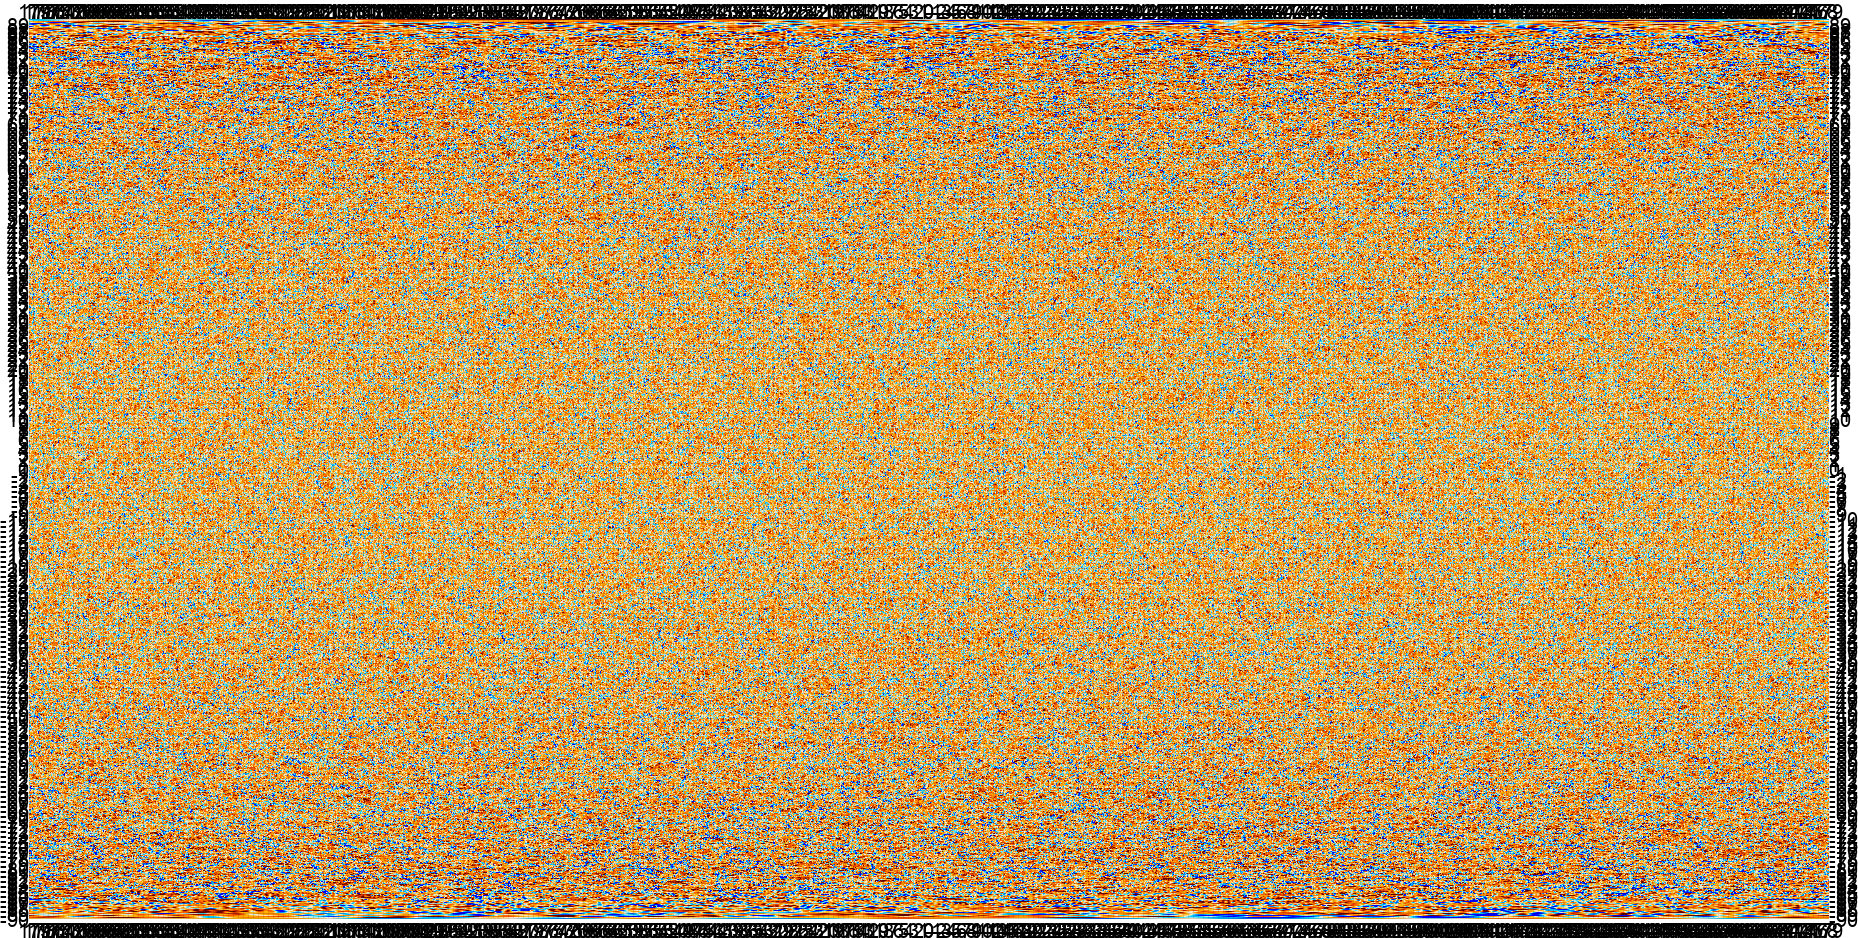

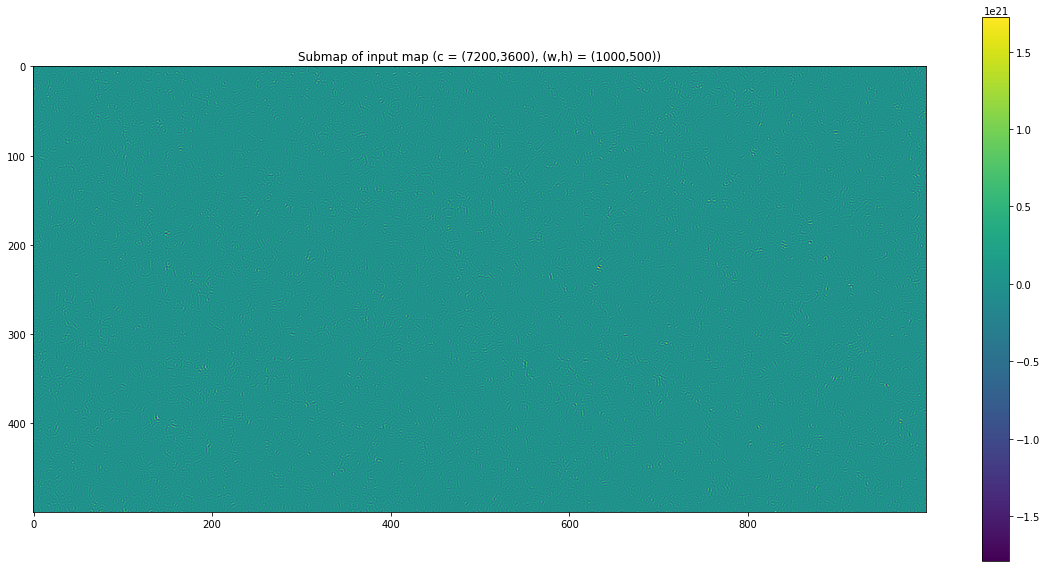

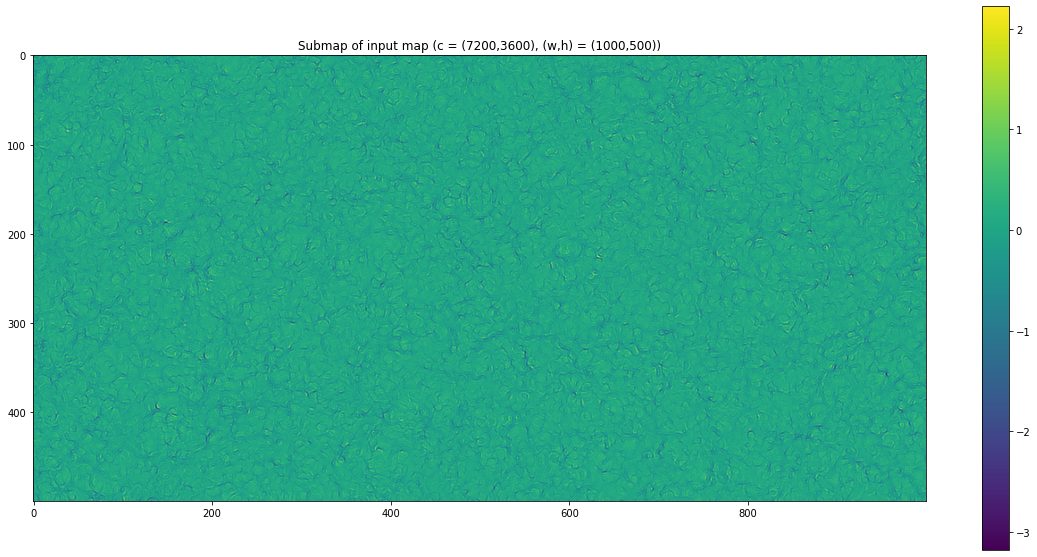

In [8]:
# enplot.plot(...,downgrade=8) 
plot = enplot.plot(kappa_map, downgrade=8)
enplot.show(plot)

josh_websky.plot_map(recon_map_only)
josh_websky.plot_map(kappa_map)

## Try stacking?

In [9]:
## generate convergence map from kap.fits file

# from given kap.fits file
RES = np.deg2rad(1.0 / 60.)
kap_px = josh_websky.px_to_car("../kap.fits", res=RES)
# filter similarly?
#kap_alms = map2alm(kap_px, lmax=LMAX)
#kap_fTalm = utils.isotropic_filter([kap_alms, kap_alms*0., kap_alms*0.],
#                                    tcls, lmin=LMIN, lmax=LMAX, ignore_te=True)[0]
kap_map = alm2map(map2alm(kap_px, lmax=LMAX), enmap.empty(shape, wcs, dtype=np.float32))
#kap_map = kap_px

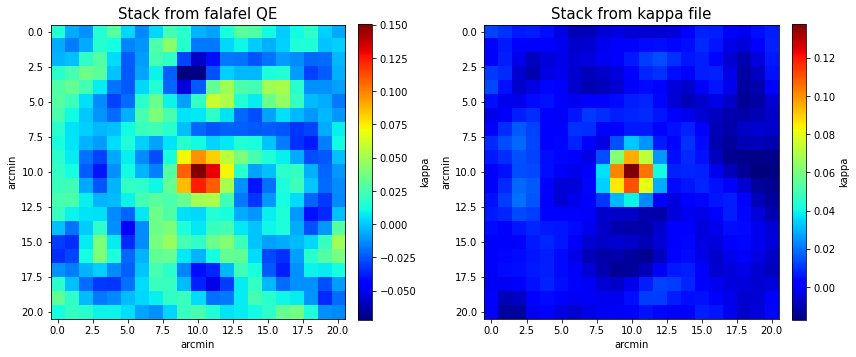

In [10]:
ra, dec = josh_websky.catalog_to_coords(filename="halos_10x10.pksc")
RES = np.deg2rad(1.0 / 60.)

# stack QE recon'd maps 
stack_map, avg_map = josh_websky.stack_average_random(kappa_map, ra, dec, Ncoords=100,
                                                      radius=10*RES, res=RES)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, ra, dec, Ncoords=100,
                                                      radius=10*RES, res=RES)                                                     

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 24))

im1 = axes[0].imshow(avg_map, cmap='jet')
axes[0].set_title("Stack from falafel QE", fontsize=15)
axes[0].set_xlabel("arcmin")
axes[0].set_ylabel("arcmin")
im2 = axes[1].imshow(avg_kap, cmap='jet')
axes[1].set_title("Stack from kappa file", fontsize=15)
axes[1].set_xlabel("arcmin")
axes[1].set_ylabel("arcmin")

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04, label="kappa")
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04, label="kappa")

plt.tight_layout()
plt.savefig("reconstruction.png", facecolor='white')
plt.show()

## Radial bins

In [11]:
# works for rectangles too!
# returns map where values represent arcmin distance from the center of the map
def distance_map(imap, res):
    [xdim, ydim] = imap.shape
    xvec, yvec = np.ones(xdim), np.ones(ydim)
    # create an array of size N, centered at 0 and incremented by pixel count
    xinds, yinds = (np.arange(xdim) + 0.5 - xdim/2.), (np.arange(ydim) + 0.5 - ydim/2.)
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    x = np.outer(xvec, yinds)
    y = np.outer(xinds, yvec)
    r = np.sqrt(x**2 + y**2)
    
    return r * res

# gonna write my own function
def radial_sum_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_lsum_own(imap, shape, wcs, bins, weights=None):
    dmap = enmap.modlmap(shape, wcs)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_avg_own(imap, res, bins, weights=None):
    
    numerator = radial_sum_own(imap, res, bins, weights)
    map_ones = 1. + enmap.empty(imap.shape, imap.wcs, dtype=np.float32)
    denominator = radial_sum_own(map_ones, res, bins, None)
    assert len(numerator) == len(denominator), "unequal sizes of numerator + denominator for averaging"
    
    return [numerator[i] / denominator[i] for i in range(len(numerator))]

def radial_avg2_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]) / len(coords))
        
    return result
        

### Trying out binning with different methods

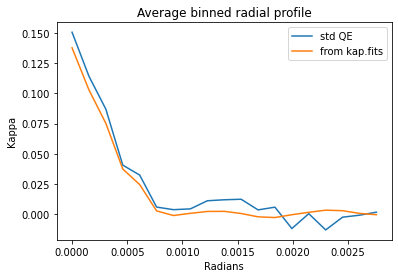

In [12]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned = radial_avg2_own(avg_map, res, res_range)

plt.title("Average binned radial profile")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned, label="std QE")
plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()

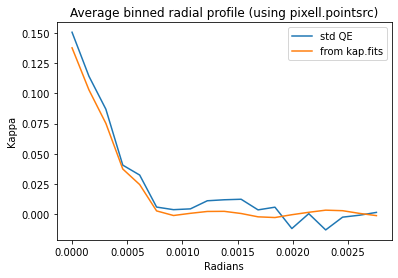

In [13]:
cent = enmap.center(avg_map.shape, avg_map.wcs)
poss = [[cent[0]], [cent[1]]]

x = np.asanyarray(poss[0], dtype=np.float32, order="C")
y = np.asanyarray(poss[1], dtype=np.float32, order="C")
#print(x)
#print(x.ndim, y.ndim)
binned2 = radial_bin(avg_map, poss, res_range)
binned_kap2 = radial_bin(avg_kap, poss, res_range)

#print(binned2[0])
plt.title("Average binned radial profile (using pixell.pointsrc)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned2[0], label="std QE")
plt.plot(res_range[:-1], binned_kap2[0], label="from kap.fits")
plt.legend()

/home/joshua/research/orphics/orphics/stats.py:761: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count


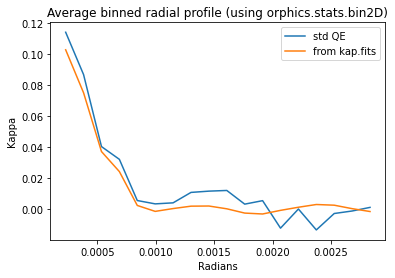

In [14]:
bin_edges = res_range
binner = stats.bin2D(distance_map(avg_map, res), bin_edges)
centers_map, binned_1d_map = binner.bin(avg_map)
centers_kap, binned_1d_kap = binner.bin(avg_kap)

plt.title("Average binned radial profile (using orphics.stats.bin2D)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(centers_map, binned_1d_map, label="std QE")
plt.plot(centers_kap, binned_1d_kap, label="from kap.fits")
plt.legend()

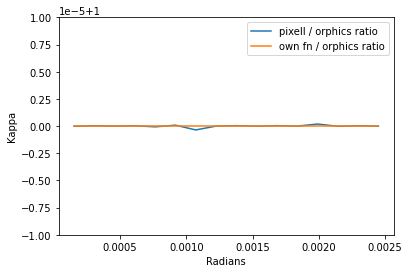

In [15]:
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.ylim(1-1e-5, 1+1e-5)
ratio_xs = res_range[:-1]
ratio_ys_pixell = binned_kap2[0] / binned_1d_kap
ratio_ys_ownfn = binned_kap / binned_1d_kap
plt.plot(ratio_xs[:-2], ratio_ys_pixell[:-2], label="pixell / orphics ratio")
plt.plot(ratio_xs[:-2], ratio_ys_ownfn[:-2], label="own fn / orphics ratio")
plt.legend()
plt.show()


## Symlens

### Set-up to generate symlens normalizations

In [16]:
SYM_LMIN = 300
SYM_LMAX = 6000
SYM_GLMIN = 300
SYM_GLMAX = 2000

sym_shape, sym_wcs = enmap.geometry(res=1.5 * putils.arcmin,pos=[0,0],shape=(2000,2000), proj='plain') 

kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_LMIN, lmax=SYM_LMAX)
g_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_LMAX)

g_kmasker = lambda l: sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=l)

new_g_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_GLMAX)

# generate a feed_dict
feed_dict = {}
feed_dict_grad = {}
NOISE_T = noise_t
BEAM_FWHM = beam_fwhm # arcmin?
modlmap = enmap.modlmap(sym_shape, sym_wcs)

# from falafel/utils.py
ells,gt,ge,gb,gte = np.loadtxt(f"{thloc}_camb_1.0.12_grads.dat",unpack=True,usecols=[0,1,2,3,4])

nells = (NOISE_T*np.pi/180./60.)**2. / sutils.gauss_beam(BEAM_FWHM,modlmap)**2.

#feed_dict_grad['uC_T_T'] = sutils.interp(ells, gt)(modlmap)
#feed_dict_grad['tC_T_T'] = feed_dict_grad['uC_T_T'] + nells
feed_dict['uC_T_T'] = theory.lCl('TT',modlmap)
feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + nells

# generate normalization
s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmask,ymask=kmask)
new_s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=new_g_kmask,ymask=kmask)

s_norms_3000 = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmasker(3000),ymask=kmask)
s_norms_4000 = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmasker(4000),ymask=kmask)
s_norms_5000 = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmasker(5000),ymask=kmask)

# print(s_norms.shape)

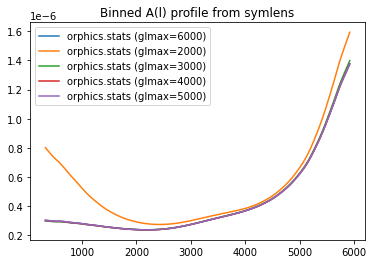

In [17]:
# radial_bin(s_norms, np.array([0., 0.]))
Lwidth = 50
Lrange = np.arange(LMIN,LMAX,Lwidth)

# sides of s_norms map go from -0.75 arcmin to 0.75 arcmin
#print(modlmap.max())
#print(enmap.corners(sym_shape, sym_wcs))

# binned_s_norms = np.array(radial_lsum_own(s_norms, sym_shape, sym_wcs, Lrange))

binner = stats.bin2D(modlmap, Lrange)
centers, stats_binned_s_norms = binner.bin(s_norms)
_, stats_binned_new_s_norms = binner.bin(new_s_norms)
_, stats_binned_3000_s_norms = binner.bin(s_norms_3000)
_, stats_binned_4000_s_norms = binner.bin(s_norms_4000)
_, stats_binned_5000_s_norms = binner.bin(s_norms_5000)

Lrange_centers = np.array([0.5 * (Lrange[i] + Lrange[i+1]) for i in range(len(Lrange)-1)])

#print(binned_s_norms)
#print(stats_binned_s_norms)

plt.title("Binned A(l) profile from symlens")
#plt.plot(Lrange[:-1], binned_s_norms * Lrange_centers**2, label="own method")
# print(centers, stats_binned_s_norms)
plt.plot(centers, stats_binned_s_norms * centers * (centers + 1), label="orphics.stats (glmax=6000)")
plt.plot(centers, stats_binned_new_s_norms * centers * (centers + 1), label="orphics.stats (glmax=2000)")
plt.plot(centers, stats_binned_3000_s_norms * centers * (centers + 1), label="orphics.stats (glmax=3000)")
plt.plot(centers, stats_binned_4000_s_norms * centers * (centers + 1), label="orphics.stats (glmax=4000)")
plt.plot(centers, stats_binned_5000_s_norms * centers * (centers + 1), label="orphics.stats (glmax=5000)")

plt.legend()
plt.show()

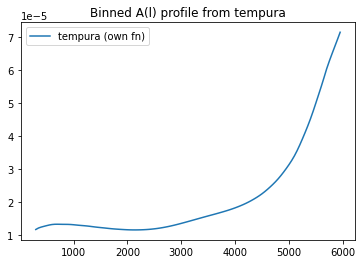

In [18]:
# aggregate values in L into a new list of Nnew indices
def listcollector(L, Nnew):
    result = []
    agg_size = len(L) // Nnew
    for i in range(Nnew):
        result.append(sum(L[i*agg_size:(i+1)*agg_size]))
    return result

#print((LMAX - LMIN) // Lwidth)
agg_kappa_norms = listcollector(kappa_norms['TT'][0][LMIN:LMAX], (LMAX - LMIN) // Lwidth)

plt.title("Binned A(l) profile from tempura")
plt.plot(Lrange, agg_kappa_norms * Lrange**4, label = "tempura (own fn)")
# factor of l^2/4 implemented
#plt.plot(centers, stats_binned_s_norms * centers**2, label="orphics.stats")
plt.legend()
plt.show()

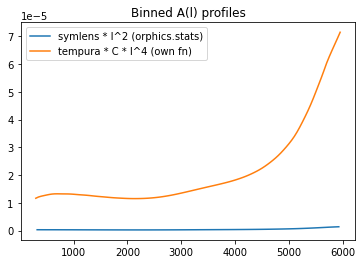

In [27]:
A_L_FACTOR = 49

plt.title("Binned A(l) profiles")
plt.plot(centers, stats_binned_s_norms * centers * (centers + 1), label="symlens * l^2 (orphics.stats)")
plt.plot(Lrange, agg_kappa_norms * Lrange**4, label = "tempura * C * l^4 (own fn)")
plt.legend()
plt.savefig("binned-als.png")
plt.show()

In [28]:
# average over each index?
INDICES = (LMAX - LMIN) // Lwidth
def symlens_filter(l, obj, lmin=LMIN, lmax=LMAX, indices=INDICES):
    if (l < lmin) or (l > lmax): return 0
    # figuring out index number in the filter structure
    length = (lmax - lmin) // indices
    i = (l - lmin) // indices
    return obj[i] / length
    
symlens_filter_L = [0]
for l in range(1, LMAX+1):
    symlens_filter_L.append(symlens_filter(l, stats_binned_s_norms) * 16 / (l**2))

#print(filt(300) / (300**2 / 46))
#print(kappa_norms['TT'][0][300])

# just trying some things, setting things up for when they should actually work out
kappa_s_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                   np.array(symlens_filter_L)))

print(len(kappa_norms['TT'][0]))
print(len(recon_alms['TT'][0]))

kappa_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                 kappa_norms['TT'][0]))


print(shape, wcs)
print(sym_shape, sym_wcs)
kappa_s_map = alm2map(kappa_s_alms, enmap.empty(shape, wcs, dtype=np.float32))

6001
18009001
(7201, 14400) car:{cdelt:[-0.025,0.025],crval:[0.0125,0],crpix:[7200.50,3601.00]}
(2000, 2000) :{cdelt:[0.025,0.025],crval:[0,0],crpix:[1000.50,1000.50]}


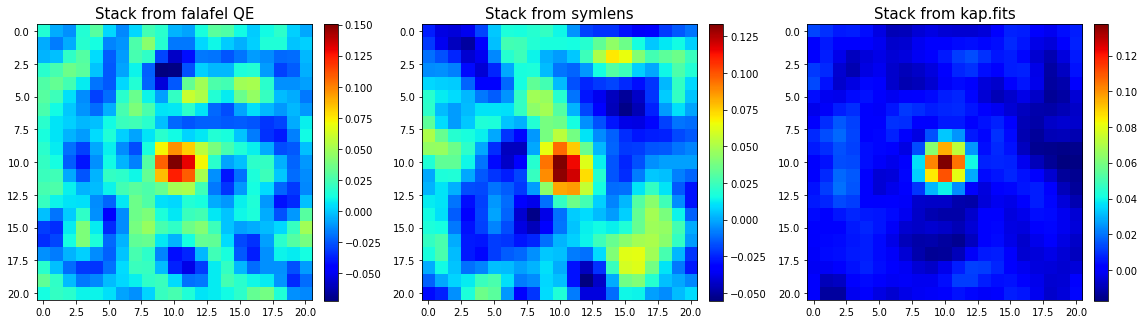

In [29]:
stack_s_map, avg_s_map = josh_websky.stack_average_random(kappa_s_map, ra, dec, Ncoords=100,
                                                          radius=10*RES, res=RES)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,36))

im1 = axes[0].imshow(avg_map, cmap='jet')
axes[0].set_title("Stack from falafel QE", fontsize=15)
im2 = axes[1].imshow(avg_s_map, cmap='jet')
axes[1].set_title("Stack from symlens", fontsize=15)
im3 = axes[2].imshow(avg_kap, cmap='jet')
axes[2].set_title("Stack from kap.fits", fontsize=15)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

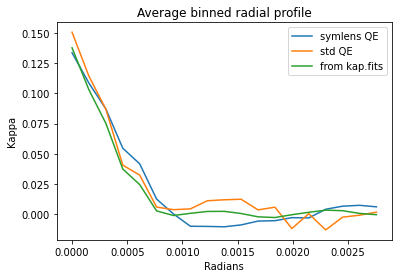

In [30]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned = radial_avg2_own(avg_map, res, res_range)
binned_skap = radial_avg2_own(avg_s_map, res, res_range)

plt.title("Average binned radial profile")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned_skap, label="symlens QE")
plt.plot(res_range[:-1], binned, label="std QE")
plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()
plt.savefig("avg-binned-radial-profiles.png")

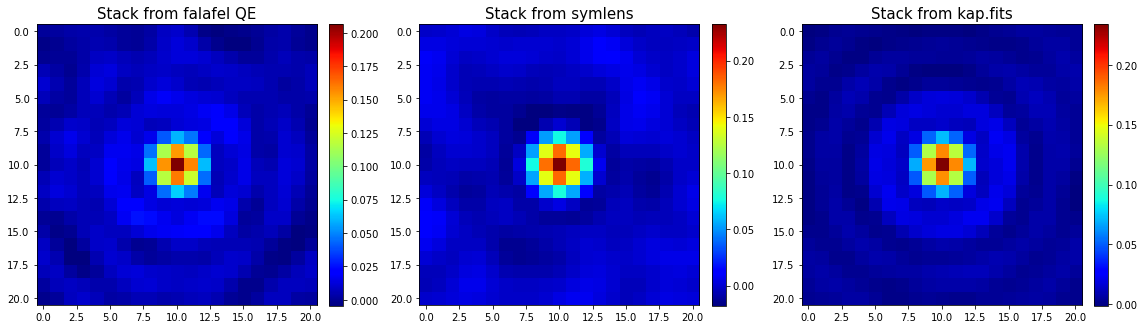

In [28]:
full_ra, full_dec = josh_websky.read_coords_from_file("1e6_massive_halos.txt")
NCOORDS = 3000
RES = np.deg2rad(1.0 / 60.)

# stack QE recon'd maps 
stack_map, avg_map = josh_websky.stack_average_random(kappa_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)           

stack_s_map, avg_s_map = josh_websky.stack_average_random(kappa_s_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                          radius=10*RES, res=RES)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,36))

im1 = axes[0].imshow(avg_map, cmap='jet')
axes[0].set_title("Stack from falafel QE", fontsize=15)
im2 = axes[1].imshow(avg_s_map, cmap='jet')
axes[1].set_title("Stack from symlens", fontsize=15)
im3 = axes[2].imshow(avg_kap, cmap='jet')
axes[2].set_title("Stack from kap.fits", fontsize=15)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("full-data-stacks.png")
plt.show()

## Mat's example code

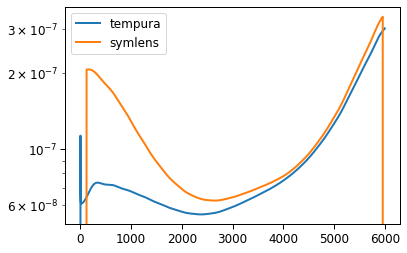

In [34]:
# %%
beam = 1.4
noise = 10.0
ucls,tcls = utils.get_theory_dicts_white_noise(beam,noise,grad=False)
lmin = 100
lmax = 6000
als_t = pytempura.get_norms(['TT'],ucls,tcls,lmin,lmax,k_ellmax=lmax)

# %%
glmax = 2000
shape,wcs = maps.rect_geometry(width_deg=10.0,px_res_arcmin=1.0,proj='plain')
xmask = maps.mask_kspace(shape,wcs,lmin=lmin,lmax=glmax)
ymask = maps.mask_kspace(shape,wcs,lmin=lmin,lmax=lmax)
kmask = maps.mask_kspace(shape,wcs,lmin=lmin,lmax=lmax)
feed_dict = {}
ells = np.arange(ucls['TT'].shape[0])
modlmap = enmap.modlmap(shape,wcs)
feed_dict['uC_T_T'] = maps.interp(ells,ucls['TT'])(modlmap)
feed_dict['tC_T_T'] = maps.interp(ells,tcls['TT'])(modlmap)
Al2d = s.qe.A_l(shape,wcs,feed_dict,'hdv','TT',xmask,ymask,kmask=kmask)

# %%
kells = np.arange(als_t['TT'][0].shape[0])

bin_edges = np.arange(lmin,lmax,40)
binner = stats.bin2D(modlmap,bin_edges)
cents,Nl1d = binner.bin(Al2d*modlmap*(modlmap+1)/4.)
Nl_sym = maps.interp(cents,Nl1d,kind='cubic')(kells)

# %%
Nl_t = als_t['TT'][0] * (kells*(kells+1)/2.)**2

pl = io.Plotter(xyscale='linlog')
pl.add(kells,Nl_t,label='tempura')
pl.add(kells,Nl_sym,label='symlens')
pl.done()
